# Третье практическое задание. Реализация дропаута в рекуррентных нейронных сетях
Практикум на ЭВМ для 317 группы, весна 2022

#### Фамилия, имя: Демьянов Иван

Дата выдачи: 3 апреля 18:00

Мягкий дедлайн: 17 апреля 23:59

Данное задание будет состоять из двух частей:
1. Применение рекуррентной сети для решения задачи классификации текста. Более конкретно -- предсказания рейтинга отзыва фильма.
2. Простейшая лингвистическая модель для генерации текста на основе LSTM.

При выполнении задания вы обучите LSTM с разным уровнем "коробочности", а также познакомитесь с различными способами применения DropOut к рекуррентным архитектурам. В рекуррентных архитектурах вариантов, куда можно наложить бинарную маску шума, гораздо больше, чем в нейросетях прямого прохода.

Во второй части вы попробуете реализовать простейший рекуррентный декодер для генерации текстов.

Задание сделано так, чтобы его можно было выполнять на CPU, однако RNN - это ресурсоёмкая вещь, поэтому на GPU с ними работать приятнее. Можете попробовать использовать [https://colab.research.google.com](https://colab.research.google.com) - бесплатное облако с GPU.

**Для корректного отображения картинок, вам может понадобится сделать ноутбук доверенным (Trusted) в правом верхнем углу**

# Часть 0. Загрузка и предобработка данных. (1 балл)

## Рекомендуемые гиперпараметры

In [3]:
max_length = 200
top_n_words = 5000

hidden_dim = 128
embedding_dim = 32

num_epochs = 15
batch_size = 64
learning_rate = 1e-3

Первое, что нужно сделать -- скачать, предобработать данные и организовать их таким образом, чтобы их можно было подавать в нейронную сеть.

Для обеих частей задания мы будем использовать [**Large Movie Review Dataset**](https://ai.stanford.edu/~amaas/data/sentiment/).

## Загрузка и предобработка данных

Загрузите данные по ссылке выше. (**tip**: используйте `wget`)

In [4]:
# YOUR CODE HERE
!wget 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar'

--2022-04-17 17:28:22--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar’

aclImdb_v1.tar      100%[===================>]  80.23M  28.9MB/s    in 2.8s    

2022-04-17 17:28:25 (28.9 MB/s) - ‘aclImdb_v1.tar’ saved [84125825/84125825]



Распакуйте скачанные данные в папку `aclImdb` (**tip:** используйте `tar`)

In [5]:
# YOUR CODE HERE
import tarfile

aclImdb = tarfile.open(name='aclImdb_v1.tar', mode='r')
aclImdb.extractall()
aclImdb.close()

Посмотрите в файле `./aclImdb/README` как организованы данные

In [6]:
! cat ./aclImdb/train/pos/10003_8.txt

This is not the typical Mel Brooks film. It was much less slapstick than most of his movies and actually had a plot that was followable. Leslie Ann Warren made the movie, she is such a fantastic, under-rated actress. There were some moments that could have been fleshed out a bit more, and some scenes that could probably have been cut to make the room to do so, but all in all, this is worth the price to rent and see it. The acting was good overall, Brooks himself did a good job without his characteristic speaking to directly to the audience. Again, Warren was the best actor in the movie, but "Fume" and "Sailor" both played their parts well.

In [7]:
test_data_path = './aclImdb/test/'
train_data_path = './aclImdb/train/'

In [1]:
!pip3 install torchtext==0.12.0

In [2]:
import torchtext
print(torchtext.__version__)

0.12.0


In [8]:
import os
from functools import partial
from collections import defaultdict

import nltk
nltk.download('stopwords')

import regex
import numpy as np

import torch
import torchtext
from torch.utils.data import Dataset, DataLoader

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Стандартной предобработкой данных является токенизация текстов. Полученные токены можно будет закодировать и затем подавать на вход нейронной сети. Ключевым моментом, который влияет на скорость работы нейросети и её размер в памяти -- размер словаря, используемого при токенизации. Для задачи классификации мы можем убрать часть слов (стоп слова, редкие слова), ускорив обучение без потери в качестве.

In [9]:
STOPWORDS = nltk.corpus.stopwords.words('english')

Реализуйте функцию для токенизации текста. Выполнять токенизацию можно по-разному, но в данном задании предлагается это делать следующим образом:
1. Привести текст к нижнему регистру
2. Убрать html разметку из текстов (`<br />`)
3. Убрать все символы кроме латинских букв
4. Разбить строку по пробелам
5. Убрать стоп слова

In [10]:
import re

def tokenize(text):
    """
    :param str text: Input text 
    :return List[str]: List of words
    """
    # YOUR CODE HERE
    text = text.lower()
    text = re.sub('<br />', '', text)
    text = re.sub('[^a-z ]', '', text).split(' ')
    return [t for t in text if t not in STOPWORDS and t!='']

In [11]:
tokenize('1. Hello <br /> words!! <br />')

['hello', 'words']

Теперь мы можем создать словарь, с помощью которого мы будем численно кодировать токены из текста и наоборот.

Удобной обёрткой для создания словарей является класс `torchtext.vocab.Vocab`.

In [ ]:
torchtext.vocab.Vocab??

Чтобы создать такой словарь, сначала нужно создать словарь со всеми токенами в тексте и их частотами встречаемости:

In [12]:
counter = defaultdict(int)

for path in ['./aclImdb/test/neg', './aclImdb/test/pos', './aclImdb/train/neg', './aclImdb/train/pos']:
    for file_path in os.listdir(path):
        text = open(os.path.join(path, file_path), 'r', encoding='utf-8', errors='ignore').read().strip()
        for token in tokenize(text):
            counter[token] += 1

Для работы с текстами нам необходимо зарезервировать два специальных токена:
1. `<pad>` для токена означающего паддинг
2. `<unk>` для токенов, которые отсутствуют в словаре

In [13]:
specials = ['<pad>', '<unk>']
for special in specials:
    counter[special] = 0

Создайте словарь из словаря частот `counter`. Наименьшие id отдайте под специальные токены. Отбросьте низкочастотные слова, оставив только `top_n_words` слов

In [14]:
from collections import Counter

c = Counter()
for i, l in counter.items():
    c[i] = l

new_counter = {}
for i, l in c.most_common(top_n_words):
    new_counter[i] = l

In [15]:
vocab = torchtext.vocab.vocab(new_counter, specials=specials, special_first=True)
vocab.set_default_index(vocab['<unk>'])

In [16]:
vocab.lookup_indices(['<pad>', '<unk>'])

[0, 1]

In [17]:
vocab.lookup_indices(['this', 'film', 'was', 'awful'])

[1, 3, 1, 272]

Теперь мы готовы создать обёртку-датасет для наших данных. 

Необходимо добавить несколько опции, которые понадобятся во второй части задания:
1. Ограничение на максимальную длину текста в токенах. Если текст оказывается длиннее, то последние токены отбрасываются
2. Возможность добавить в специальные токены `<sos>`, `<eos>` в начало и конец токенизированного текста
    
**tips:**
1. Обратите особое внимание, что у длинных текстов не должен обрезаться паддинг
2. В исходных данных рейтинг закодирован в названии файла в виде числа от 1 до 10. Для удобства, вычтите 1, чтобы рейтинг был от 0 до 9

In [18]:
class LargeMovieReviewDataset(Dataset):
    def __init__(self, data_path, vocab, max_len, pad_sos=False, pad_eos=False):
        """
        :param str data_path: Path to folder with one of the data splits (train or test)
        :param torchtext.vocab.Vocab vocab: dictionary with lookup_indices method
        :param int max_len: Maximum length of tokenized text
        :param bool pad_sos: If True pad sequence at the beginning with <sos> 
        :param bool pad_eos: If True pad sequence at the end with <eos>         
        """
        super().__init__()
        
        self.pad_sos = pad_sos
        if self.pad_sos:
            self.sos_id = vocab.lookup_indices(['<sos>'])[0]
        self.pad_eos = pad_eos
        if self.pad_eos:
            self.eos_id = vocab.lookup_indices(['<eos>'])[0]
        
        self.vocab = vocab
        self.max_len = max_len
        self.data_path = data_path
        self.negative_path = os.path.join(data_path, 'neg')
        self.positive_path = os.path.join(data_path, 'pos')
        
        self.negative_paths = []
        self.positive_paths = []

        for file_path in os.listdir(self.negative_path):
            self.negative_paths.append(os.path.join(self.negative_path, file_path))

        for file_path in os.listdir(self.positive_path):
            self.positive_paths.append(os.path.join(self.positive_path, file_path))
        
        self.texts = []
        self.tokens = []
        self.ratings = []
        self.labels = [0] * len(self.negative_paths) + [1] * len(self.positive_paths)
        
        # Read each file in data_path, tokenize it, get tokens ids, its rating and store
        for path in self.negative_paths + self.positive_paths:
            # YOUR CODE HERE
            with open(path) as f:
                text = f.read()
                self.texts.append(text)
                text_tokens = []
                if self.pad_sos:
                    text_tokens.append(self.sos_id)
                for token in tokenize(text)[:self.max_len]:
                    text_tokens.append(vocab.lookup_indices([token])[0])
                if self.pad_eos:
                    text_tokens.append(self.eos_id)
                self.tokens.append(torch.tensor(text_tokens, dtype=torch.long))
                self.ratings.append(int(path.split('_')[-1].split('.')[0]) - 1)
        
    def __getitem__(self, idx):
        """
        :param int idx: index of object in dataset
        :return dict: Dictionary with all useful object data 
            {
                'text' str: unprocessed text,
                'label' torch.tensor(dtype=torch.long): sentiment of the text (0 for negative, 1 for positive)
                'rating' torch.tensor(dtype=torch.long): rating of the text
                'tokens' torch.tensor(dtype=torch.long): tensor of tokens ids for the text
                'tokens_len' torch.tensor(dtype=torch.long): number of tokens
            }
        """
        # YOUR CODE HERE
        # Do not forget to add padding if needed!
        return {
            'text': self.texts[idx],
            'label': torch.tensor(self.labels[idx], dtype=torch.long),
            'rating': torch.tensor(self.ratings[idx], dtype=torch.long),
            'tokens': self.tokens[idx],
            'tokens_len': torch.tensor(self.tokens[idx].size(0), dtype=torch.long)
        }
    
    def __len__(self):
        """
        :return int: number of objects in dataset 
        """
        # YOUR CODE HERE
        return len(self.texts)

Создайте датасеты для тестовой и обучающей выборки. 

Обратите внимание, что для задачи классификации нам не потребуется паддинг с помощью `<sos>`, `<eos>`. 

Не забудьте обрезать длинные тексты, передав параметр `max_length`.

In [19]:
# YOUR CODE HERE
test_dataset = LargeMovieReviewDataset(test_data_path, vocab, max_length)
train_dataset = LargeMovieReviewDataset(train_data_path, vocab, max_length)

Посмотрим, как выглядит объект в датасете:

In [20]:
test_dataset[0]

{'label': tensor(0),
 'rating': tensor(2),
 'text': 'You know, I\'m getting really tired of all the generic music being used in these type of movies (see Jawbreaker, Disturbing Behavior, etc). Every scene of genuine tension here (and there is some) is immediately undercut with some cheesy pop tune, completely diluting the suspense. Why do they do that? To sell some soundtracks, of course, but in this case, mission unaccomplished - did anyone buy the CD?<br /><br />And yeah, Ms. Mirren attacks her role with zest and relish (with some cheez-wiz to add kick). But what are Molly, Leslie and Vivica doing here? Their roles (they\'re so underused that I cannot use "characters" here) have no purpose in the storyline, so I can\'t figure out why three well-known actresses had been cast.<br /><br />Oh, and the ending is so unbelievably hackneyed and irresponsible. The kids get off scot-free and act as if nothing happened - all smiles at graduation. They\'re criminals, people! No consequences for 

Теперь нам нужно создать `DataLoader` для наших данных. `DataLoader` умеет из коробки объединять список объектов из датасета в один батч, даже когда датасет возвращает словарь тензоров. Однако, это работает только в случае когда все эти тензоры имеют один и тот же размер во всех батчах. В нашем случае, это не так, так как разные тексты могут иметь разную длину.

Чтобы обойти эту проблему у `DataLoader` есть параметр `collate_fn`, который позволяет задать функцию для объединения списка объектов в один батч.

Чтобы объединить несколько тензоров разной длины в один можно использовать функцию `torch.nn.utils.rnn.pad_sequence`

Обратите внимание на её аргументы:
1. `batch_first` определяет по какой оси "складывать" тензоры. Предпочтительнее использовать `batch_first=False` так как это может упростить выполнение задания в дальнейшем 
2. `padding_value` -- число, которое будет использоваться в качестве паддинга, чтобы сделать все тензоры одинаковой длины

In [21]:
torch.nn.utils.rnn.pad_sequence([
    torch.tensor([1, 2, 3]),
    torch.tensor([4, 5]),
    torch.tensor([6, 7, 8, 9])
], batch_first=False, padding_value=-1)

tensor([[ 1,  4,  6],
        [ 2,  5,  7],
        [ 3, -1,  8],
        [-1, -1,  9]])

In [22]:
def collate_fn(batch, padding_value, batch_first=False):
    """
    :param List[Dict] batch: List of objects from dataset
    :param int padding_value: Value that will be used to pad tokens
    :param bool batch_first: If True resulting tensor with tokens must have shape [B, T] otherwise [T, B]
    :return dict: Dictionary with all data collated
        {
            'ratings' torch.tensor(dtype=torch.long): rating of the text for each object in batch
            'labels' torch.tensor(dtype=torch.long): sentiment of the text for each object in batch
            
            'texts' List[str]: All texts in one list
            'tokens' torch.tensor(dtype=torch.long): tensor of tokens ids padded with @padding_value
            'tokens_lens' torch.tensor(dtype=torch.long): number of tokens for each object in batch
        }
    """
    # YOUR CODE HERE
    d = batch[0].copy()
    replacements = {'text': 'texts', 'label': 'labels', 'rating': 'ratings',
                    'tokens_len': 'tokens_lens'}
    for i in list(d.keys()):
        if i in replacements.keys():
            d[replacements[i]] = d.pop(i)
    tokens = [d['tokens']]
    for obj in batch[1:]:
        d['texts'] += obj['text']

        d['ratings'] = torch.cat((d['ratings'].reshape(-1), obj['rating'].reshape(-1)))
        d['labels'] = torch.cat((d['labels'].reshape(-1), obj['label'].reshape(-1)))
        d['tokens_lens'] = torch.cat((d['tokens_lens'].reshape(-1), obj['tokens_len'].reshape(-1)))
        tokens.append(obj['tokens'])
    
    d['tokens'] = torch.nn.utils.rnn.pad_sequence(tokens, batch_first=batch_first,
                                                        padding_value=padding_value)
    return d

Создайте даталоадеры с использованием `collate_fn`.

**tips**:
1. Передать в `collate_fn` правильное значение паддинга можно, например, с помощью `functools.partial`
2. Если вы работаете в Google Colab, то, возможно, вам будет необходимо установить `num_workers=0` во избежание падения ноутбука.

In [23]:
# YOUR CODE HERE
from functools import partial

new_collate = partial(collate_fn, padding_value=0, batch_first=False)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                             collate_fn=new_collate, shuffle=True, num_workers=0)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              collate_fn=new_collate, shuffle=True, num_workers=0)

Посмотрим на какой-нибудь батч:

In [24]:
batch = next(iter(test_dataloader))
batch.keys(), batch['labels'], batch['ratings'], batch['tokens'], batch['tokens_lens']

(dict_keys(['tokens', 'texts', 'labels', 'ratings', 'tokens_lens']),
 tensor([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
         1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1]),
 tensor([2, 8, 1, 9, 2, 2, 0, 3, 9, 0, 0, 8, 9, 0, 0, 3, 3, 8, 0, 9, 2, 3, 8, 7,
         8, 3, 6, 8, 8, 2, 2, 0, 0, 8, 7, 9, 6, 7, 0, 6, 7, 0, 9, 9, 9, 9, 0, 9,
         7, 0, 2, 0, 0, 2, 0, 0, 8, 7, 0, 1, 0, 9, 0, 9]),
 tensor([[  55,    2,   58,  ...,   21,    2,    1],
         [  95,   16,    6,  ..., 1481,   29, 1345],
         [ 213,  902,    2,  ...,   19,  891, 4458],
         ...,
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]]),
 tensor([175,  46,  46,  63,  56, 101, 117,  64, 200,  66,  96,  50,  99, 118,
          80,  65, 186,  29,  99,  22,  36, 200,  54,  63,  77, 161, 157, 20

# Часть 1. Классификация текстов. (6 баллов)

## Сборка и обучение RNN в pytorch (2 балла)

Создадим переменные для device-agnostic кода:

In [25]:
dtype, device, cuda_device_id = torch.float32, None, 0
os.environ["CUDA_VISIBLE_DEVICES"] = '{0}'.format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = 'cuda:{0:d}'.format(0)
else:
    device = torch.device('cpu')
print(f'Using device: {device}, dtype: {dtype}')

Using device: cuda:0, dtype: torch.float32


Наша нейросеть будет обрабатывать входную последовательность по словам (word level). Мы будем использовать простую и стандартную рекуррентную архитектуру для классификации:
1. Слой представлений, превращающий id токена в вектор-ембеддинг этого слова
2. Слой LSTM
3. Полносвязный слой, предсказывающий выход по последнему скрытому состоянию

Ниже дан код для сборки и обучения нашей нейросети.

Допишите класс-обёртку над LSTM для задачи классификации. 
**Не используйте циклы.**

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [26]:
class RNNClassifier(torch.nn.Module):
    def __init__(
        self, embedding_dim, hidden_dim, output_size, vocab,
        rec_layer=torch.nn.LSTM, dropout=None, **kwargs
    ):
        super().__init__()

        self.dropout = dropout
        
        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        
        # Create a simple lookup table that stores embeddings of a fixed dictionary and size.
        #    Use torch.nn.Embedding. Do not forget specify padding_idx!
        # YOUR CODE HERE
        self.word_embeddings = torch.nn.Embedding(len(self.vocab), self.embedding_dim, padding_idx=0)
        
        if dropout is not None:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, dropout=self.dropout, **kwargs)
        else:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, **kwargs)
         
        # Create linear layer for classification
        # YOUR CODE HERE
        self.output = torch.nn.Linear(self.hidden_dim, self.output_size, bias=False)
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.tensor(dtype=torch.long) tokens: Batch of texts represented with tokens.
        :param torch.tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch.
        :return torch.tensor(dtype=torch.long): Vector representation for each sequence in batch
        """
        # Evaluate embeddings
        # YOUR CODE HERE
        layer1 = self.word_embeddings(tokens) # layer1[max_length, batch_size, embedding_dim]
        
        # Make forward pass through recurrent network
        # YOUR CODE HERE
        out, hidden = self.rnn(layer1) # out:[max_length, batch_size, self.hidden_dim]
        # hidden: ([1, batch_size, self.hidden_dim], [1, batch_size, self.hidden_dim])
        
        # Pass output from rnn to linear layer 
        # Note: each object in batch has its own length 
        #     so we must take rnn hidden state after the last token for each text in batch
        # YOUR CODE HERE
        return self.output(out[tokens_lens-1, torch.arange(out.size(1)), :]) #[batch_size, output_size]

[Исходный код LSTM](http://pytorch.org/docs/master/_modules/torch/nn/modules/rnn.html#LSTM)

Допишите функции для обучения и оценки модели:

**tip:**
1. В функции `evaluate` при подсчёте метрик учитывайте, что батчи могут иметь разный размер. (в частности последний батч)

In [27]:
def train_epoch(dataloader, model, loss_fn, optimizer, device):
    #model = model.to(device)
    model.train()
    for idx, data in enumerate(dataloader):
        # 1. Take data from batch
        # 2. Perform forward pass
        # 3. Evaluate loss
        # 4. Make optimizer step
        # YOUR CODE HERE
        optimizer.zero_grad()
        tokens, tokens_lens = data['tokens'].to(device), data['tokens_lens'].to(device)
        labels = data['ratings'].to(device)
        predict = model(tokens, tokens_lens)
        loss = loss_fn(predict, labels)
        loss.backward()
        optimizer.step()    
    
def evaluate(dataloader, model, loss_fn, device):
    #model = model.to(device)
    model.eval()
    
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            # 2. Perform forward pass
            # 3. Evaluate loss
            # 4. Evaluate accuracy
            # YOUR CODE HERE
            tokens, tokens_lens = data['tokens'].to(device), data['tokens_lens'].to(device)
            labels = data['ratings'].to(device)
            predict = model(tokens, tokens_lens)
            total_loss += loss_fn(predict, labels)
            total_accuracy += torch.sum((torch.argmax(predict, dim=1) == labels))
    return total_loss / len(dataloader.dataset), total_accuracy / len(dataloader.dataset)

def train(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Создадим модель:

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=torch.nn.LSTM, dropout=None
).to(device)

Создадим класс для подсчёта функции потерь и оптимизатор:

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Попробуем обучить модель:

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [ ]:
import time

t_start = time.perf_counter()

train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

all_time = time.perf_counter() - t_start
print(f'working time is {all_time//60:.0f}m {all_time%60:.0f}s')

Epoch: 1/15. Loss (Train/Test): 1.892/1.901. Accuracy (Train/Test): 0.301/0.306
Epoch: 2/15. Loss (Train/Test): 1.743/1.767. Accuracy (Train/Test): 0.341/0.341
Epoch: 3/15. Loss (Train/Test): 1.623/1.678. Accuracy (Train/Test): 0.369/0.357
Epoch: 4/15. Loss (Train/Test): 1.545/1.627. Accuracy (Train/Test): 0.393/0.374
Epoch: 5/15. Loss (Train/Test): 1.464/1.586. Accuracy (Train/Test): 0.431/0.383
Epoch: 6/15. Loss (Train/Test): 1.437/1.584. Accuracy (Train/Test): 0.441/0.384
Epoch: 7/15. Loss (Train/Test): 1.354/1.565. Accuracy (Train/Test): 0.468/0.399
Epoch: 8/15. Loss (Train/Test): 1.322/1.576. Accuracy (Train/Test): 0.486/0.396
Epoch: 9/15. Loss (Train/Test): 1.258/1.579. Accuracy (Train/Test): 0.511/0.394
Epoch: 10/15. Loss (Train/Test): 1.198/1.617. Accuracy (Train/Test): 0.537/0.385
Epoch: 11/15. Loss (Train/Test): 1.132/1.644. Accuracy (Train/Test): 0.568/0.386
Epoch: 12/15. Loss (Train/Test): 1.057/1.687. Accuracy (Train/Test): 0.604/0.378
Epoch: 13/15. Loss (Train/Test): 0.98

Нерегуляризованные LSTM часто быстро переобучаются (и мы это видим по точности на контроле). Чтобы с этим бороться, часто используют L2-регуляризацию и дропаут.
Однако способов накладывать дропаут на рекуррентный слой достаточно много, и далеко не все хорошо работают. По [ссылке](https://medium.com/@bingobee01/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b) доступен хороший обзор дропаутов для RNN.

Мы реализуем два варианта DropOut для RNN (и третий дополнительно). Заодно увидим, что для реализации различных усовершенствований рекуррентной архитектуры приходится "вскрывать" слой до различной "глубины".

## Реализация дропаута по статье Гала и Гарамани. Variational Dropout. (1 балл)

Начнем с дропаута, описанного в [статье Гала и Гарамани](https://arxiv.org/abs/1512.05287).
Для этого нам потребуется перейти от использования слоя `torch.nn.LSTM`, полностью скрывающего от нас рекуррентную логику, к использованию слоя `torch.nn.LSTMCell`, обрабатывающего лишь один временной шаг нашей последовательности (а всю логику вокруг придется реализовать самостоятельно). 

Допишите класс `RNNLayer`. При `dropout=0` ваш класс должен работать как обычный слой LSTM, а при `dropout > 0` накладывать бинарную маску на входной и скрытый вектор на каждом временном шаге, причем эта маска должна быть одинаковой во все моменты времени.

Дропаут Гала и Гарамани в виде формул (m обозначает маску дропаута):

$$
h_{t-1} = h_{t-1}*m_h, \, x_t = x_t * m_x
$$

Далее обычный шаг рекуррентной архитектуры, например, LSTM:

$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t) \nonumber
$$

In [28]:
def init_h0_c0(num_objects, hidden_size, some_existing_tensor):
    """
    return h0 and c0, use some_existing_tensor.new_zeros() to gen them
    h0 shape: num_objects x hidden_size
    c0 shape: num_objects x hidden_size
    """
    # YOUR CODE HERE
    h_0 = some_existing_tensor.new_zeros(num_objects, hidden_size)
    c_0 = some_existing_tensor.new_zeros(num_objects, hidden_size)
    return h_0, c_0

In [29]:
def gen_dropout_mask(input_size, hidden_size, is_training, p, some_existing_tensor):
    """
    is_training: if True, gen masks from Bernoulli
                 if False, gen masks consisting of (1-p)
    
    return dropout masks of size input_size, hidden_size if p is not None
    return one masks if p is None
    """
    # YOUR CODE HERE
    if p is None:
        m_x = some_existing_tensor.new_ones(input_size)
        h_x = some_existing_tensor.new_ones(hidden_size)
        return m_x, h_x
    if is_training:
        m_x = torch.bernoulli((1-p) * some_existing_tensor.new_ones(input_size))
        h_x = torch.bernoulli((1-p) * some_existing_tensor.new_ones(hidden_size))
    else:
        m_x = (1-p) * some_existing_tensor.new_ones(input_size)
        h_x = (1-p) * some_existing_tensor.new_ones(hidden_size)
    return m_x, h_x

Допишите класс-обёртку над LSTMCell для реализации Variational Dropout. **Используйте только цикл по времени**

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [30]:
class RNNLayer(torch.nn.Module) :
    def __init__(self, input_size, hidden_size, dropout=None):
        super().__init__()

        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.rnn_cell = torch.nn.LSTMCell(self.input_size, self.hidden_size)
        
    def forward(self, x):
        # Initialize h_0, c_0
        # YOUR CODE HERE
        h0, c0 = init_h0_c0(x.size(1), self.hidden_size, x)
        # x[max_length, batch_size, embedding_dim]
        # h0, c0, h_t, c_t[batch_size, hidden_dim]
        
        # Gen masks for input and hidden state
        # YOUR CODE HERE
        m_x, h_x = gen_dropout_mask(self.input_size, self.hidden_size,
                                    self.training, self.dropout, x)
        #m_x[embedding_dim]
        #h_x[hidden_dim]

        # Implement recurrent logic and return what nn.LSTM returns
        # Do not forget to apply generated dropout masks!
        # YOUR CODE HERE
        out = []
        h_t, c_t = h0, c0
        for t in range(x.size(0)):
            h_t, c_t = self.rnn_cell(x[t]*m_x, (h_t*h_x, c_t))
            m_x, h_x = gen_dropout_mask(self.input_size, self.hidden_size,
                                    self.training, self.dropout, x)
            out.append(h_t)
        return torch.stack(out), (h_t, c_t)

Протестируйте реализованную модель с выключенным дропаутом (слой `RNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Сильно ли оно увеличилось по сравнению с `torch.nn.LSTM` (LSTM "из коробки")?

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10,
    vocab=vocab, rec_layer=RNNLayer, dropout=None 
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

t_start = time.perf_counter()

train_losses_vd_no_drop, train_accuracies_vd_no_drop, test_losses_vd_no_drop, test_accuracies_vd_no_drop = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

all_time = time.perf_counter() - t_start
print(f'working time is {all_time//60:.0f}m {all_time%60:.0f}s')

Epoch: 1/15. Loss (Train/Test): 1.992/1.997. Accuracy (Train/Test): 0.238/0.244
Epoch: 2/15. Loss (Train/Test): 1.772/1.800. Accuracy (Train/Test): 0.333/0.329
Epoch: 3/15. Loss (Train/Test): 1.670/1.727. Accuracy (Train/Test): 0.359/0.344
Epoch: 4/15. Loss (Train/Test): 1.569/1.652. Accuracy (Train/Test): 0.383/0.347
Epoch: 5/15. Loss (Train/Test): 1.484/1.605. Accuracy (Train/Test): 0.415/0.384
Epoch: 6/15. Loss (Train/Test): 1.410/1.580. Accuracy (Train/Test): 0.444/0.388
Epoch: 7/15. Loss (Train/Test): 1.371/1.592. Accuracy (Train/Test): 0.459/0.396
Epoch: 8/15. Loss (Train/Test): 1.320/1.580. Accuracy (Train/Test): 0.484/0.390
Epoch: 9/15. Loss (Train/Test): 1.256/1.592. Accuracy (Train/Test): 0.507/0.390
Epoch: 10/15. Loss (Train/Test): 1.178/1.618. Accuracy (Train/Test): 0.540/0.388
Epoch: 11/15. Loss (Train/Test): 1.118/1.652. Accuracy (Train/Test): 0.569/0.384
Epoch: 12/15. Loss (Train/Test): 1.055/1.689. Accuracy (Train/Test): 0.597/0.381
Epoch: 13/15. Loss (Train/Test): 0.97

Время обучения данной модели 5 раз больше, чем у LSTM "из коробки".

Протестируйте полученную модель с `dropout=0.25`, вновь замерив время обучения. Получилось ли побороть переобучение? Сильно ли дольше обучается данная модель по сравнению с предыдущей? (доп. время тратится на генерацию масок дропаута).

In [ ]:
# YOUR CODE HERE
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10,
    vocab=vocab, rec_layer=RNNLayer, dropout=0.25
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

t_start = time.perf_counter()

train_losses_vd_drop, train_accuracies_vd_drop, test_losses_vd_drop, test_accuracies_vd_drop = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

all_time = time.perf_counter() - t_start
print(f'working time is {all_time//60:.0f}m {all_time%60:.0f}s')

Epoch: 1/15. Loss (Train/Test): 1.989/1.991. Accuracy (Train/Test): 0.252/0.253
Epoch: 2/15. Loss (Train/Test): 1.777/1.791. Accuracy (Train/Test): 0.329/0.334
Epoch: 3/15. Loss (Train/Test): 1.663/1.696. Accuracy (Train/Test): 0.358/0.356
Epoch: 4/15. Loss (Train/Test): 1.577/1.631. Accuracy (Train/Test): 0.384/0.376
Epoch: 5/15. Loss (Train/Test): 1.543/1.620. Accuracy (Train/Test): 0.399/0.376
Epoch: 6/15. Loss (Train/Test): 1.483/1.572. Accuracy (Train/Test): 0.421/0.382
Epoch: 7/15. Loss (Train/Test): 1.440/1.544. Accuracy (Train/Test): 0.433/0.399
Epoch: 8/15. Loss (Train/Test): 1.417/1.550. Accuracy (Train/Test): 0.443/0.392
Epoch: 9/15. Loss (Train/Test): 1.379/1.523. Accuracy (Train/Test): 0.460/0.403
Epoch: 10/15. Loss (Train/Test): 1.349/1.533. Accuracy (Train/Test): 0.472/0.400
Epoch: 11/15. Loss (Train/Test): 1.323/1.518. Accuracy (Train/Test): 0.478/0.412
Epoch: 12/15. Loss (Train/Test): 1.295/1.517. Accuracy (Train/Test): 0.490/0.406
Epoch: 13/15. Loss (Train/Test): 1.27

Как видно, данная модель лучше справляется с переобучением. Данная обучается немного дольше по сравнению с предыдущей. 

## Реализация дропаута по статье Гала и Гарамани. Дубль 2 (1 балл)

<начало взлома pytorch>

При разворачивании цикла по времени средствами python обучение рекуррентной нейросети сильно замедляется. Однако для реализации дропаута Гала и Гарамани необязательно явно задавать в коде домножение нейронов на маски. Можно схитрить и обойтись использованием слоя `torch.nn.LSTM`: перед вызовом `forward` слоя `torch.nn.LSTM` подменять его веса на веса, домноженные по строкам на маски. А обучаемые веса хранить отдельно. Именно так этот дропаут реализован в библиотеке `fastai`, код из которой использован в ячейке ниже.

Такой слой реализуется в виде обертки над `torch.nn.LSTM`. Допишите класс:

In [32]:
import warnings

In [33]:
class FastRNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0, layers_dropout=0.0, num_layers=1):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.num_layers = num_layers

        self.dropout = dropout
        self.layers_dropout = layers_dropout
        self.module = torch.nn.LSTM(input_size, hidden_size, dropout=layers_dropout, num_layers=num_layers)

        self.layer_names = []
        for layer_n in range(self.num_layers):
            self.layer_names += [f'weight_hh_l{layer_n}', f'weight_ih_l{layer_n}']

        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights from torch.nn.LSTM instance
            w = getattr(self.module, layer)

            # Remove it from model
            delattr(self.module, layer)

            # And create new torch.nn.Parameter with the same data but different name
            self.register_parameter(f'{layer}_raw', torch.nn.Parameter(w.data))

            # Note. In torch.nn.LSTM.forward parameter with name `layer` will be used
            #     so we must initialize it using `layer_raw` before forward pass

    def _setweights(self, x):
        """
            Apply dropout to the raw weights.
        """
        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights
            raw_w = getattr(self, f'{layer}_raw')

            # Generate mask (use function gen_dropout_mask)
            # YOUR CODE HERE
            w_mask, _ = gen_dropout_mask(raw_w.size(1), 0, self.training, self.dropout, x)

            # Apply dropout mask
            # YOUR CODE HERE
            masked_raw_w = raw_w * w_mask

            # Set modified weights in its place
            setattr(self.module, layer, masked_raw_w)

    def forward(self, x, h_c=None):
        """
        :param x: tensor containing the features of the input sequence.
        :param Optional[Tuple[torch.tensor, torch.tensor]] h_c: initial hidden state and initial cell state
        """
        with warnings.catch_warnings():
            # To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")

            # Set new weights of self.module and call its forward
            # Pass h_c with x if it is not None. Otherwise pass only x
            # YOUR CODE HERE
            self._setweights(x)
            if h_c is not None:
                return self.module(x, h_c)
            return self.module(x)
            
    def reset(self):
        if hasattr(self.module, 'reset'):
            self.module.reset()

Протестируйте реализованную модель с выключенным дропаутом (слой `FastRNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Убедитесь, что модель выдаёт такое же качество, как и оригинальная реализация LSTM.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [ ]:
# YOUR CODE HERE
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10,
    vocab=vocab, rec_layer=FastRNNLayer, dropout=None 
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

t_start = time.perf_counter()

train_losses_vd2_no_drop, train_accuracies_vd2_no_drop, test_losses_vd2_no_drop, test_accuracies_vd2_no_drop = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

all_time = time.perf_counter() - t_start
print(f'working time is {all_time//60:.0f}m {all_time%60:.0f}s')

Epoch: 1/15. Loss (Train/Test): 1.942/1.947. Accuracy (Train/Test): 0.280/0.281
Epoch: 2/15. Loss (Train/Test): 1.697/1.728. Accuracy (Train/Test): 0.352/0.344
Epoch: 3/15. Loss (Train/Test): 1.569/1.634. Accuracy (Train/Test): 0.393/0.364
Epoch: 4/15. Loss (Train/Test): 1.506/1.603. Accuracy (Train/Test): 0.410/0.385
Epoch: 5/15. Loss (Train/Test): 1.437/1.575. Accuracy (Train/Test): 0.441/0.382
Epoch: 6/15. Loss (Train/Test): 1.376/1.565. Accuracy (Train/Test): 0.455/0.395
Epoch: 7/15. Loss (Train/Test): 1.338/1.560. Accuracy (Train/Test): 0.467/0.402
Epoch: 8/15. Loss (Train/Test): 1.313/1.607. Accuracy (Train/Test): 0.489/0.382
Epoch: 9/15. Loss (Train/Test): 1.205/1.625. Accuracy (Train/Test): 0.523/0.393
Epoch: 10/15. Loss (Train/Test): 1.147/1.636. Accuracy (Train/Test): 0.558/0.378
Epoch: 11/15. Loss (Train/Test): 1.077/1.697. Accuracy (Train/Test): 0.581/0.380
Epoch: 12/15. Loss (Train/Test): 0.984/1.773. Accuracy (Train/Test): 0.623/0.379
Epoch: 13/15. Loss (Train/Test): 0.90

Протестируйте полученный слой (вновь подставив его в `RNNClassifier` в качестве `rec_layer`) с `dropout=0.25`. Сравните время обучения с предыдущими моделями. Проследите, чтобы качество получилось такое же, как при первой реализации этого дропаута.

In [ ]:
# YOUR CODE HERE
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10,
    vocab=vocab, rec_layer=FastRNNLayer, dropout=0.25
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

t_start = time.perf_counter()

train_losses_vd2_drop, train_accuracies_vd2_drop, test_losses_vd2_drop, test_accuracies_vd2_drop = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

all_time = time.perf_counter() - t_start
print(f'working time is {all_time//60:.0f}m {all_time%60:.0f}s')

Epoch: 1/15. Loss (Train/Test): 2.010/2.011. Accuracy (Train/Test): 0.229/0.228
Epoch: 2/15. Loss (Train/Test): 1.836/1.844. Accuracy (Train/Test): 0.318/0.320
Epoch: 3/15. Loss (Train/Test): 1.691/1.717. Accuracy (Train/Test): 0.357/0.349
Epoch: 4/15. Loss (Train/Test): 1.603/1.643. Accuracy (Train/Test): 0.380/0.369
Epoch: 5/15. Loss (Train/Test): 1.554/1.612. Accuracy (Train/Test): 0.397/0.380
Epoch: 6/15. Loss (Train/Test): 1.499/1.569. Accuracy (Train/Test): 0.413/0.392
Epoch: 7/15. Loss (Train/Test): 1.461/1.549. Accuracy (Train/Test): 0.428/0.397
Epoch: 8/15. Loss (Train/Test): 1.433/1.534. Accuracy (Train/Test): 0.437/0.403
Epoch: 9/15. Loss (Train/Test): 1.402/1.520. Accuracy (Train/Test): 0.451/0.409
Epoch: 10/15. Loss (Train/Test): 1.380/1.522. Accuracy (Train/Test): 0.457/0.404
Epoch: 11/15. Loss (Train/Test): 1.359/1.524. Accuracy (Train/Test): 0.464/0.406
Epoch: 12/15. Loss (Train/Test): 1.336/1.515. Accuracy (Train/Test): 0.473/0.417
Epoch: 13/15. Loss (Train/Test): 1.32

По результатам обучения можно отметить, что модели с реализацией дропаута в этом разделе имеют схожее качество с предыдущими, однако обучаются в несколько раз быстрее.

</конец взлома pytorch>

## Реализация дропаута по статье Семениуты и др. (1 балл)

Перейдем к реализации дропаута для LSTM по статье [Semeniuta et al](http://www.aclweb.org/anthology/C16-1165). 

Этот метод применения дропаута не менее популярен, чем предыдущий. Его особенность состоит в том, что он придуман специально для гейтовых архитектур. В контексте LSTM этот дропаут накладывается только на информационный поток (m_h - маска дропаута):
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot g \odot {\bf m_h} \quad
h_t =  o \odot tanh(c_t) \nonumber
$$
На входы $x_t$ маска накладывается как в предыдущем дропауте. Впрочем, на входы маску можно наложить вообще до вызова рекуррентного слоя.

Согласно статье, маска дропаута может быть как одинаковая, так и разная для всех моментов времени. Мы сделаем одинаковую для всех моментов времени.

Для реализации этого дропаута можно: 
1. самостоятельно реализовать LSTM (интерфейса LSTMCell не хватит) 
2. снова воспользоваться трюком с установкой весов (но тут мы опираемся на свойство $tanh(0)=0$, к тому же, трюк в данном случае выглядит менее тривиально, чем с дропаутом Гала). 

Предлагается реализовать дропаут по сценарию 1. Допишите класс:

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [34]:
class HandmadeLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0):
        super().__init__()
        
        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.input_weights = torch.nn.Linear(input_size, 4 * hidden_size)
        self.hidden_weights = torch.nn.Linear(hidden_size, 4 * hidden_size)
        
        self.reset_params()

    def reset_params(self):
        """
        Initialization as in Pytorch. 
        Do not forget to call this method!
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#LSTM
        """
        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            torch.nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x):
        # Use functions init_h0_c0 and gen_dropout_masks defined above
        # YOUR CODE HERE
        h0, c0 = init_h0_c0(x.size(1), self.hidden_size, x)
        m_x, h_x = gen_dropout_mask(self.input_size, self.hidden_size,
                                    self.training, self.dropout, x)
        # x[max_length, batch_size, embedding_dim]
        # h0, c0, h_t, c_t[batch_size, hidden_dim]
        # m_x[embedding_dim], h_x[hidden_dim]

        # Implement recurrent logic to mimic torch.nn.LSTM
        # Do not forget to apply dropout mask
        # YOUR CODE HERE
        out = []
        h_t, c_t = h0, c0
        for t in range(x.size(0)):
            iofg = self.hidden_weights(h_t)+self.input_weights(x[t]*m_x) #iofg[batch_size, 4*hidden_dim]
            i = torch.sigmoid(iofg[:, :self.hidden_size])
            o = torch.sigmoid(iofg[:,self.hidden_size:2*self.hidden_size])
            f = torch.sigmoid(iofg[:,2*self.hidden_size:3*self.hidden_size])
            g = torch.tanh(iofg[..., 3*self.hidden_size:])
            #i, o, f, g : torch.tensor([batch_size, hidden_dim])
            c_t = f*c_t + i*g*h_x
            h_t = o * torch.tanh(c_t)
            out.append(h_t)
        return torch.stack(out), (h_t, c_t)

Протестируйте вашу реализацию без дропаута (проконтролируйте качество и сравните время обучения с временем обучения `torch.nn.LSTM` и `RNNLayer`), а также с `dropout=0.25`. Сравните качество модели с таким дропаутом с качеством модели с дропаутом Гала и Гарамани.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10,
    vocab=vocab, rec_layer=HandmadeLSTM, dropout=None
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

t_start = time.perf_counter()

train_losses_no_drop3, train_accuracies_no_drop3, test_losses_no_drop3, test_accuracies_no_drop3 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

all_time = time.perf_counter() - t_start
print(f'working time is {all_time//60:.0f}m {all_time%60:.0f}s')

Epoch: 1/15. Loss (Train/Test): 1.974/1.976. Accuracy (Train/Test): 0.270/0.272
Epoch: 2/15. Loss (Train/Test): 1.690/1.722. Accuracy (Train/Test): 0.351/0.350
Epoch: 3/15. Loss (Train/Test): 1.611/1.664. Accuracy (Train/Test): 0.375/0.353
Epoch: 4/15. Loss (Train/Test): 1.518/1.609. Accuracy (Train/Test): 0.406/0.380
Epoch: 5/15. Loss (Train/Test): 1.471/1.604. Accuracy (Train/Test): 0.420/0.368
Epoch: 6/15. Loss (Train/Test): 1.389/1.564. Accuracy (Train/Test): 0.458/0.390
Epoch: 7/15. Loss (Train/Test): 1.327/1.557. Accuracy (Train/Test): 0.479/0.396
Epoch: 8/15. Loss (Train/Test): 1.275/1.607. Accuracy (Train/Test): 0.498/0.394
Epoch: 9/15. Loss (Train/Test): 1.223/1.613. Accuracy (Train/Test): 0.525/0.379
Epoch: 10/15. Loss (Train/Test): 1.145/1.642. Accuracy (Train/Test): 0.550/0.396
Epoch: 11/15. Loss (Train/Test): 1.068/1.707. Accuracy (Train/Test): 0.584/0.383
Epoch: 12/15. Loss (Train/Test): 0.998/1.749. Accuracy (Train/Test): 0.624/0.368
Epoch: 13/15. Loss (Train/Test): 0.90

In [ ]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10,
    vocab=vocab, rec_layer=HandmadeLSTM, dropout=0.25
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

t_start = time.perf_counter()

train_losses_drop3, train_accuracies_drop3, test_losses_drop3, test_accuracies_drop3 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

all_time = time.perf_counter() - t_start
print(f'working time is {all_time//60:.0f}m {all_time%60:.0f}s')

Epoch: 1/15. Loss (Train/Test): 2.033/2.038. Accuracy (Train/Test): 0.205/0.202
Epoch: 2/15. Loss (Train/Test): 2.003/2.010. Accuracy (Train/Test): 0.271/0.278
Epoch: 3/15. Loss (Train/Test): 1.775/1.791. Accuracy (Train/Test): 0.335/0.338
Epoch: 4/15. Loss (Train/Test): 1.677/1.703. Accuracy (Train/Test): 0.355/0.350
Epoch: 5/15. Loss (Train/Test): 1.640/1.682. Accuracy (Train/Test): 0.364/0.359
Epoch: 6/15. Loss (Train/Test): 1.600/1.656. Accuracy (Train/Test): 0.375/0.361
Epoch: 7/15. Loss (Train/Test): 1.550/1.620. Accuracy (Train/Test): 0.395/0.373
Epoch: 8/15. Loss (Train/Test): 1.519/1.601. Accuracy (Train/Test): 0.404/0.381
Epoch: 9/15. Loss (Train/Test): 1.499/1.597. Accuracy (Train/Test): 0.417/0.383
Epoch: 10/15. Loss (Train/Test): 1.476/1.578. Accuracy (Train/Test): 0.418/0.379
Epoch: 11/15. Loss (Train/Test): 1.463/1.572. Accuracy (Train/Test): 0.420/0.395
Epoch: 12/15. Loss (Train/Test): 1.426/1.561. Accuracy (Train/Test): 0.437/0.401
Epoch: 13/15. Loss (Train/Test): 1.41

Точность на тесте у данных моделей схожа с качеством модели с дропаутом Гала и Гарамани, время обучения дольше.

## Сравнение всех предложенных моделей. (1 балл)

Используя замеры времени заполните табличку с временем работы четырёх реализованных моделей в следующей ячейке:

| dropout\model | torch.nn.LSTM | RNNLayer | FastRNNLayer | HandmadeLSTM |
|---------------|---------------|----------|--------------|--------------|
|      None     | 2m 14s        | 10m 45s  | 2m 20s       | 22m 3s       |
|      0.25     | ______        | 12m 47s  | 2m 20s       | 21m 55s      |

In [ ]:
import matplotlib.pyplot as plt

Крайне желательно рисовать графики в векторном формате. 

Если по каким-то причинам, отрисовка не будет работать, закомментируйте следующую ячейку.

In [ ]:
%matplotlib inline

from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

Нарисуйте два графика -- функция потерь и качество на обучающей и тестовой выборке для всех 7 моделей обученных выше.

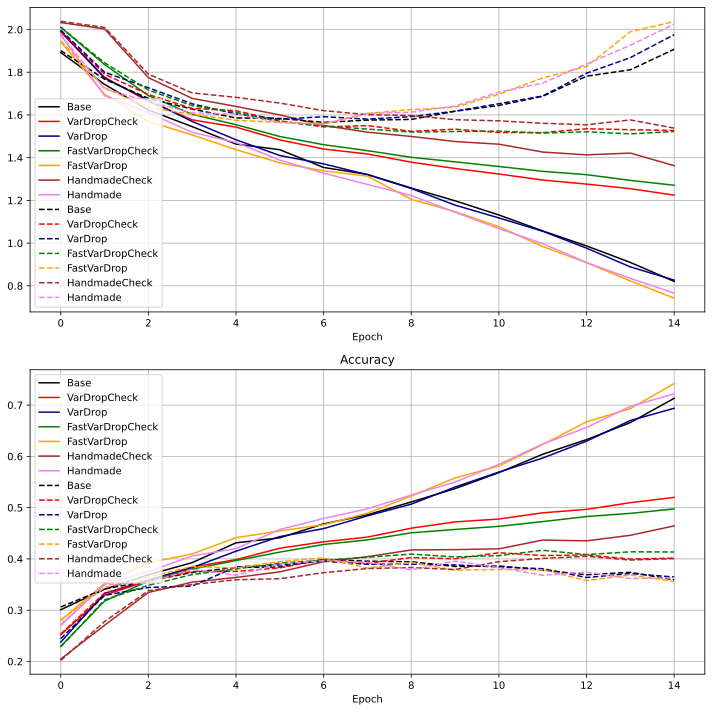

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# YOUR CODE HERE

axes[0].grid(True)
axes[0].plot(np.arange(len(train_losses_pure)), [i.item() for i in train_losses_pure],
             label='Base', linestyle='-', color='black')

axes[0].plot(np.arange(len(train_losses_vd_drop)), [i.item() for i in train_losses_vd_drop],
             label='VarDropCheck', linestyle='-', color='red')
axes[0].plot(np.arange(len(train_losses_vd_no_drop)), [i.item() for i in train_losses_vd_no_drop],
             label='VarDrop', linestyle='-', color='darkblue')

axes[0].plot(np.arange(len(train_losses_vd2_drop)), [i.item() for i in train_losses_vd2_drop],
             label='FastVarDropCheck', linestyle='-', color='green')
axes[0].plot(np.arange(len(train_losses_vd2_no_drop)), [i.item() for i in train_losses_vd2_no_drop],
             label='FastVarDrop', linestyle='-', color='orange')

axes[0].plot(np.arange(len(train_losses_drop3)), [i.item() for i in train_losses_drop3],
             label='HandmadeCheck', linestyle='-', color='brown')
axes[0].plot(np.arange(len(train_losses_no_drop3)), [i.item() for i in train_losses_no_drop3],
             label='Handmade', linestyle='-', color='violet')

axes[0].plot(np.arange(len(test_losses_pure)), [i.item() for i in test_losses_pure],
             label='Base', linestyle='--', color='black')

axes[0].plot(np.arange(len(test_losses_vd_drop)), [i.item() for i in test_losses_vd_drop],
             label='VarDropCheck', linestyle='--', color='red')
axes[0].plot(np.arange(len(test_losses_vd_no_drop)), [i.item() for i in test_losses_vd_no_drop],
             label='VarDrop', linestyle='--', color='darkblue')

axes[0].plot(np.arange(len(test_losses_vd2_drop)), [i.item() for i in test_losses_vd2_drop],
             label='FastVarDropCheck', linestyle='--', color='green')
axes[0].plot(np.arange(len(test_losses_vd2_no_drop)), [i.item() for i in test_losses_vd2_no_drop],
             label='FastVarDrop', linestyle='--', color='orange')

axes[0].plot(np.arange(len(test_losses_drop3)), [i.item() for i in test_losses_drop3],
             label='HandmadeCheck', linestyle='--', color='brown')
axes[0].plot(np.arange(len(test_losses_no_drop3)), [i.item() for i in test_losses_no_drop3],
             label='Handmade', linestyle='--', color='violet')

axes[0].legend()
axes[0].set_xlabel('Epoch')

axes[1].grid(True)

axes[1].plot(np.arange(len(train_accuracies_pure)), [i.item() for i in train_accuracies_pure],
             label='Base', linestyle='-', color='black')

axes[1].plot(np.arange(len(train_accuracies_vd_drop)), [i.item() for i in train_accuracies_vd_drop],
             label='VarDropCheck', linestyle='-', color='red')
axes[1].plot(np.arange(len(train_accuracies_vd_no_drop)), [i.item() for i in train_accuracies_vd_no_drop],
             label='VarDrop', linestyle='-', color='darkblue')

axes[1].plot(np.arange(len(train_accuracies_vd2_drop)), [i.item() for i in train_accuracies_vd2_drop],
             label='FastVarDropCheck', linestyle='-', color='green')
axes[1].plot(np.arange(len(train_accuracies_vd2_no_drop)), [i.item() for i in train_accuracies_vd2_no_drop],
             label='FastVarDrop', linestyle='-', color='orange')

axes[1].plot(np.arange(len(train_accuracies_drop3)), [i.item() for i in train_accuracies_drop3],
             label='HandmadeCheck', linestyle='-', color='brown')
axes[1].plot(np.arange(len(train_accuracies_no_drop3)), [i.item() for i in train_accuracies_no_drop3],
             label='Handmade', linestyle='-', color='violet')

axes[1].plot(np.arange(len(test_accuracies_pure)), [i.item() for i in test_accuracies_pure],
             label='Base', linestyle='--', color='black')

axes[1].plot(np.arange(len(test_accuracies_vd_drop)), [i.item() for i in test_accuracies_vd_drop],
             label='VarDropCheck', linestyle='--', color='red')
axes[1].plot(np.arange(len(test_accuracies_vd_no_drop)), [i.item() for i in test_accuracies_vd_no_drop],
             label='VarDrop', linestyle='--', color='darkblue')

axes[1].plot(np.arange(len(test_accuracies_vd2_drop)), [i.item() for i in test_accuracies_vd2_drop],
             label='FastVarDropCheck', linestyle='--', color='green')
axes[1].plot(np.arange(len(test_accuracies_vd2_no_drop)), [i.item() for i in test_accuracies_vd2_no_drop],
             label='FastVarDrop', linestyle='--', color='orange')

axes[1].plot(np.arange(len(test_accuracies_drop3)), [i.item() for i in test_accuracies_drop3],
             label='HandmadeCheck', linestyle='--', color='brown')
axes[1].plot(np.arange(len(test_accuracies_no_drop3)), [i.item() for i in test_accuracies_no_drop3],
             label='Handmade', linestyle='--', color='violet')
axes[1].legend()
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Сделайте итоговые выводы о качестве работы моделей с разными реализациями DropOut:

**Ответ:** модели FastVarDropCheck и HandmadeCheck показывают схожее качество на обучении и на тесте, что свидетельствует об устойчивости к проблеме переобучения. Также по графикам видно, что все модели с включенным дропаутом более усточивы к переобучению, чем их аналоги с выключенным дропаутом.

P.S. На графиках пунктир означает тест, префикс "Check" - модель с парметром dropout=0.25.

## Бонус. Zoneout (2 балла)

Это еще одна модификация идеи дропаута применительно к рекуррентным нейросетям. В Zoneout на каждом временном шаге с вероятностью p компонента скрытого состояния обновляется, а с вероятностью 1-p берется с предыдущего шага. 
В Виде формул (m^t_h - бинарная маска):
 
(сначала обычный рекуррентный переход, например LSTM)
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t) \nonumber
$$
Затем Zoneout:
$$
h_t = h_t * m_h^t + h_{t-1}*(1-m_h^t)
$$
В этом методе маска уже должна быть разная во все моменты времени (иначе метод упрощается до дропаута Гала и Гарамани). На входы $x_t$ вновь можно накладывать маску до начала работы рекуррентного слоя.  

Если у вас осталось время, вы можете реализовать этот метод. Выберите основу из трех рассмотренных случаев самостоятельно.

In [ ]:
class Zoneout(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0):
        super().__init__()
        
        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.input_weights = torch.nn.Linear(input_size, 4 * hidden_size)
        self.hidden_weights = torch.nn.Linear(hidden_size, 4 * hidden_size)
        
        self.reset_params()

    def reset_params(self):
        """
        Initialization as in Pytorch. 
        Do not forget to call this method!
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#LSTM
        """
        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            torch.nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x):
        # Use functions init_h0_c0 and gen_dropout_masks defined above
        # YOUR CODE HERE
        h0, c0 = init_h0_c0(x.size(1), self.hidden_size, x)
        m_x, h_x = gen_dropout_mask(self.input_size, self.hidden_size,
                                    self.training, self.dropout, x)   
        # Implement recurrent logic to mimic torch.nn.LSTM
        # Do not forget to apply dropout mask
        # YOUR CODE HERE
        out = []
        h_t, c_t = h0, c0
        for t in range(x.size(0)):
            iofg = self.hidden_weights(h_t)+self.input_weights(x[t]*m_x)
            i = torch.sigmoid(iofg[:, :self.hidden_size])
            o = torch.sigmoid(iofg[:,self.hidden_size:2*self.hidden_size])
            f = torch.sigmoid(iofg[:,2*self.hidden_size:3*self.hidden_size])
            g = torch.tanh(iofg[..., 3*self.hidden_size:])
            c_t = f*c_t + i*g
            h_t = o * torch.tanh(c_t)
            _, h_x = gen_dropout_mask(self.input_size, self.hidden_size,
                                    self.training, self.dropout, x) 
            h_t = h_t * h_x + out[-1] * (1-h_x)
            out.append(h_t)
        return torch.stack(out), (h_t, c_t)

# Часть 2. Language Modeling с помощью LSTM. (3 балла)

Во второй части мы попробуем обучить модель для генерации отзывов по их началу.

Концептуально модель будет выглядеть следующим образом:
    
![image info](https://blog.feedly.com/wp-content/uploads/2019/03/Screen-Shot-2019-03-06-at-12.08.35-PM.png)

В процессе обучения будем тренировать сеть предсказывать вероятность следующего символа при условии всех предыдущих. Эту вероятность можно моделировать с помощью скрытого состояния $h^{(t)}$ пропуская его через линейный слой с выходной размерностью равной размерности словаря:
$$
p(x^{t}|x^{t-1}, ..., x^{1}) = SoftMax(Linear(h^{(t)}))
$$

Обратите внимание, что для вычисления $p(x^{t}|x^{t-1}, ..., x^{1})$ для всех моментов времени достаточно сделать один проход по RNN, а затем применить линейное преобразование ко всем скрытым состояниям.

В качестве функции потерь необходимо использовать `CrossEntropy`.

Рассмотрим другой важный момент. Для того, чтобы решить данную задачу, модель должна уметь определять момент начала генерации предложения и оповещать о завершении генерации -- конце предложения. Для этого добавим в словарь вспомогательные токены `<sos>`, `<eos>`. Добавив `<sos>` в начало каждого предложения и `<eos>` в конец.

Модель сможет начинать генерацию как только ей будет передан токен `<sos>` и заканчивать генерацию, как только на очередном месте самым вероятным токеном оказывается `<eos>`.

Для решения этой задачи мы воспользуемся уже реализованной LSTM с дропаутом `FastRNNLayer` и классом `RNNClassifier`, то есть архитектура сети принципиально не поменяется. 

## Реализация модели и цикла обучения (1 балл)

**Не используйте циклы в `RNNLM`, `LMCrossEntropyLoss`, `LMAccuracy`**

In [78]:
class RNNLM(RNNClassifier):
    def __init__(
        self, embedding_dim, hidden_dim, vocab, dropout=0.5, layers_dropout=0.5, num_layers=1
    ):
        super().__init__(
            embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=len(vocab), vocab=vocab,
            rec_layer=FastRNNLayer, dropout=dropout, layers_dropout=layers_dropout, num_layers=num_layers
        )
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.tensor(dtype=torch.long) tokens: Batch of texts represented with tokens. Shape: [T, B]
        :param torch.tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch. Shape: [B]
        :return torch.tensor: Distribution of next token for each time step. Shape: [T, B, V], V -- size of vocabulary
        """
        # Make embeddings for all tokens
        # YOUR CODE HERE
        layer1 = self.word_embeddings(tokens)
        
        # Forward pass embeddings through network
        # YOUR CODE HERE
        out_h, hidden = self.rnn(layer1)
        # Take all hidden states from the last layer of LSTM for each step and perform linear transformation
        # YOUR CODE HERE
        return self.output(out_h)

Реализуем функцию потерь для данной задачи. 

Моменты на которые нужно обратить внимание:
1. Распределение вероятности следующего токена для последнего токена в последовательности не участвует в подсчёте функции потерь.
2. Необходимо учитывать, что в одном батче могут быть тексты разной длины.

Для решения второй проблемы можно воспользоваться функцией `torch.nn.utils.rnn.pack_padded_sequence`. 

Принимая на вход батч тензоров и длину каждого тензора без учёта паддинга эта функция позволяет получить все элементы в тензорах, которые не относятся к паддингу в виде плоского массива:

In [79]:
padded_tensors = torch.tensor([
    [[1, 11, 111], [2, 22, 222], [3, 33, 333]],
    [[4, 44, 444], [5, 55, 555], [6, 66, 666]],
    [[7, 77, 777], [0, 0, 0], [8, 88, 888]],
    [[9, 99, 999], [0, 0, 0], [0, 0, 0]]
])
tensors_lens = torch.tensor([4, 2, 3])

In [80]:
padded_tensors.shape

torch.Size([4, 3, 3])

Обратите внимание, что `torch.nn.utils.rnn.pack_padded_sequence` автоматически переупорядочивает тензоры в батче по убыванию их длины.

In [81]:
torch.nn.utils.rnn.pack_padded_sequence(padded_tensors, tensors_lens, batch_first=False, enforce_sorted=False)#[0]

PackedSequence(data=tensor([[  1,  11, 111],
        [  3,  33, 333],
        [  2,  22, 222],
        [  4,  44, 444],
        [  6,  66, 666],
        [  5,  55, 555],
        [  7,  77, 777],
        [  8,  88, 888],
        [  9,  99, 999]]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

In [82]:
class LMCrossEntropyLoss(torch.nn.CrossEntropyLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.tensor tokens_lens: Length of each sequence in batch
        :return torch.tensor: CrossEntropyLoss between corresponding logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first
        # YOUR CODE HERE
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(outputs, tokens_lens.cpu()-1, 
                                                                 batch_first=False, enforce_sorted=False).data
        packed_tokens = torch.nn.utils.rnn.pack_padded_sequence(tokens[1:], tokens_lens.cpu()-1, 
                                                                batch_first=False, enforce_sorted=False).data
        
        # Use super().forward(..., ...) to compute CrossEntropyLoss
        # YOUR CODE HERE
        return super().forward(packed_outputs, packed_tokens)

Для оценки качества нам также необходимо вычислять долю правильно предсказанных токенов. Реализуйте класс для вычисления точности.

In [83]:
class LMAccuracy(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.tensor tokens_lens: Length of each sequence in batch
        :return torch.tensor: Accuracy for given logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first
        # YOUR CODE HERE
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(outputs, tokens_lens.cpu()-1, 
                                                                 batch_first=False, enforce_sorted=False).data
        packed_tokens = torch.nn.utils.rnn.pack_padded_sequence(tokens[1:, :], tokens_lens.cpu()-1,
                                                                batch_first=False, enforce_sorted=False).data

        return torch.sum(packed_outputs.argmax(1) == packed_tokens)

Модифицируйте функции `train_epoch`, `evaluate`, `train` для обучения LM.

**При вычислении точности, обратите внимание на то, что мы не предсказываем первый токен в каждой последовательности и токены, относящиеся к паддингу.**

In [84]:
def train_epoch_lm(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        # 1. Take data from batch
        # 2. Perform forward pass
        # 3. Evaluate loss
        # 4. Make optimizer step
        # YOUR CODE HERE
        optimizer.zero_grad()
        tokens, tokens_lens = data['tokens'].to(device), data['tokens_lens'].to(device)
        predict = model(tokens, tokens_lens)
        loss = loss_fn(predict, tokens, tokens_lens)
        loss.backward()
        optimizer.step()
    
def evaluate_lm(dataloader, model, loss_fn, device):
    model.eval()
    
    total_tokens = 0
    total_loss = 0.0
    total_accuracy = 0.0
    
    accuracy_fn = LMAccuracy()
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            # 2. Perform forward pass
            # 3. Evaluate loss
            # 4. Evaluate accuracy
            # YOUR CODE HERE
            tokens, tokens_lens = data['tokens'].to(device), data['tokens_lens'].to(device)
            predict = model(tokens, tokens_lens).to(device)
            
            total_loss += loss_fn(predict, tokens, tokens_lens)
            total_accuracy += accuracy_fn(predict, tokens, tokens_lens)
            total_tokens += torch.sum(tokens_lens - 1)          
    return total_loss / total_tokens, total_accuracy / total_tokens

def train_lm(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch_lm(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate_lm(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate_lm(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Теперь у нас всё готово для обучения модели.

Создадим словарь с `<sos>`, `<eos>` токенами.

Обратите внимание, что в отличие от классификации текстов нам необходимо значительно увеличить размер словаря, чтобы доля `<unk>` токенов была не велика.

Так же, так как задача генерации значительно сложнее задачи классификации текстов будем обучать модель только на префиксах рецензий длины $20$. Это позволяет значительно ускорить обучение.

In [85]:
from collections import Counter

c = Counter()
for i, l in counter.items():
    c[i] = l

new_counter = {}
for i, l in c.most_common(30000):
    new_counter[i] = l

In [86]:
specials = ['<pad>', '<unk>', '<sos>', '<eos>']
for special in specials:
    counter[special] = 0
lm_vocab = torchtext.vocab.vocab(new_counter, specials=specials, special_first=True)
lm_vocab.set_default_index(vocab['<unk>'])

In [87]:
# max_len=18 с учетом еще 2х специальных токенов

lm_test_dataset = LargeMovieReviewDataset(test_data_path, lm_vocab, max_len=18, pad_sos=True, pad_eos=True)
lm_train_dataset = LargeMovieReviewDataset(train_data_path, lm_vocab, max_len=18, pad_sos=True, pad_eos=True)

Создадим даталоадеры для тестовой и обучающей выборок:

In [88]:
lm_test_dataloader = DataLoader(
    lm_test_dataset, batch_size=96, shuffle=False, num_workers=0, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)
lm_train_dataloader = DataLoader(
    lm_train_dataset, batch_size=96, shuffle=True, num_workers=0, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)

Убедитесь, что все предложения имеют в начале `<sos>` токен, а в конце -- `<eos>` токен.

In [89]:
batch = next(iter(lm_train_dataloader))
batch['tokens'], batch['tokens_lens']

(tensor([[    2,     2,     2,  ...,     2,     2,     2],
         [  882,   874,  1128,  ...,  4237,    58,  1067],
         [  687,   166,   148,  ...,   298,   736,     8],
         ...,
         [ 1774, 10247,   610,  ...,    49, 24392,  1054],
         [  335,   117,    21,  ...,  1355,     1,   245],
         [    3,     3,     3,  ...,     3,     3,     3]]),
 tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20]))

In [90]:
lm_vocab.lookup_indices(['<sos>', '<eos>'])

[2, 3]

Создадим модель, функцию потерь и оптимизатор: 

In [91]:
lm_model = RNNLM(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, dropout=0.6, layers_dropout=0.6, num_layers=2
).to(device=device)

In [92]:
lm_loss_fn = LMCrossEntropyLoss(reduction='sum')
lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=0.005, weight_decay=1.2e-6)

Обучим модель:

In [93]:
lm_train_losses, lm_train_accuracies, lm_test_losses, lm_test_accuracies = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, 10
)

Epoch: 1/10. Loss (Train/Test): 7.449/7.611. Accuracy (Train/Test): 0.092/0.092
Epoch: 2/10. Loss (Train/Test): 7.258/7.511. Accuracy (Train/Test): 0.098/0.098
Epoch: 3/10. Loss (Train/Test): 7.092/7.445. Accuracy (Train/Test): 0.102/0.102
Epoch: 4/10. Loss (Train/Test): 6.952/7.412. Accuracy (Train/Test): 0.107/0.106
Epoch: 5/10. Loss (Train/Test): 6.827/7.396. Accuracy (Train/Test): 0.108/0.107
Epoch: 6/10. Loss (Train/Test): 6.729/7.408. Accuracy (Train/Test): 0.110/0.109
Epoch: 7/10. Loss (Train/Test): 6.633/7.437. Accuracy (Train/Test): 0.111/0.109
Epoch: 8/10. Loss (Train/Test): 6.484/7.429. Accuracy (Train/Test): 0.113/0.110
Epoch: 9/10. Loss (Train/Test): 6.406/7.484. Accuracy (Train/Test): 0.114/0.111
Epoch: 10/10. Loss (Train/Test): 6.290/7.524. Accuracy (Train/Test): 0.114/0.110


## Реализация декодера. (2 балла)

Теперь, реализуем последнюю деталь -- декодирование с использованием обученной модели.
Есть несколько вариантов. Рассмотрим два самых простых:
1. **Жадное декодирование.** На каждом шаге мы выбираем токен с максимальной вероятностью и используем его для обновления скрытого состояния RNN.
2. **Top-k sampling.** На очередном шаге рассматриваются $k$ токенов с самыми большими вероятностями. Остальные токены игнорируются. Из выбранных токенов семплируется следующий токен пропорционально их вероятностям.

Прочитать подробнее про разные варианты декодирования можно по ссылкам:
1. [От huggingface](https://huggingface.co/blog/how-to-generate)
2. [На towardsdatascience](https://towardsdatascience.com/decoding-strategies-that-you-need-to-know-for-response-generation-ba95ee0faadc)

Существенным в процессе декодирования является критерий останова. Как только очередной самый вероятный символ оказался `<eos>`, то данная последовательность считается сгенерированной. Однако, может так оказаться, что `<eos>` никогда не будет выбран, тогда необходимо прекратить генерацию, как только длина последовательности перейдёт порог `max_generated_len`.

In [311]:
def decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=None):
    """
    :param RNNLM model: Model
    :param torch.tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :return Tuple[torch.tensor, torch.tensor]. Newly predicted tokens and length of generated part. Shape [T*, B], [B]
    """
    # Get embedding for start_tokens
    # YOUR CODE HERE
    embedding = model.word_embeddings(start_tokens)

    # Pass embedding through rnn and collect hidden states and cell states for each time moment
    all_h, all_c = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        output, (h, c) = model.rnn(torch.unsqueeze(embedding[time_step], dim=0), (h, c))
        all_h.append(h)
        all_c.append(c)

    all_h = torch.stack(all_h, dim=1)
    all_c = torch.stack(all_c, dim=1)
    # Take final hidden state and cell state for each start sequence in batch
    # We will use them as h_0, c_0 for generation new tokens
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]

    # List of predicted tokens for each time step
    predicted_tokens = []
    # Length of generated part for each object in the batch
    decoded_lens = torch.zeros_like(start_tokens_lens, dtype=torch.long)
    # Boolean mask where we store if the sequence has already generated
    # i.e. `<eos>` was selected on any step
    is_finished_decoding = torch.zeros_like(start_tokens_lens, dtype=torch.bool)

    # Stop when all sequences in the batch are finished
    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        # Evaluate next token distribution using hidden state h.
        # Note. Over first dimension h has hidden states for each layer of LSTM.
        #     We must use hidden state from the last layer
        # YOUR CODE HERE
        logits = model.output(h[-1])

        if top_k is not None:
            # Top-k sampling. Use only top-k most probable logits to sample next token
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            # Mask non top-k logits
            logits[indices_to_remove] = -1e10
            # Sample next_token. 
            # YOUR CODE HERE
            next_token = torch.multinomial(torch.sigmoid(logits), 1).reshape(-1)
        else:
            # Select most probable token
            # YOUR CODE HERE
            next_token = torch.argmax(logits, dim=1).reshape(-1)

        predicted_tokens.append(next_token)

        decoded_lens += (~is_finished_decoding)
        is_finished_decoding |= (next_token == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))

        # Evaluate embedding for next token
        embedding += model.word_embeddings(next_token)

        # Update hidden and cell states
        output, (h, c) = model.rnn(embedding, (h, c))

    return torch.stack(predicted_tokens), decoded_lens

Попробуем сгенерировать продолжения для нескольких префиксов:

In [312]:
start_tokens = torch.tensor([
    lm_model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    lm_model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'best', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'worst', 'movie']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [313]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=5)

In [314]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> first time episode time thought thought im watching <unk> watching movie film going saw <unk> watching film im im hooked
<sos> <unk> favorite movie seen ive never watched seen heard watched movie watched dvd dvd <eos>
<sos> <unk> best movie ive seen seen ever heard heard seen movie saw <unk> <unk> watched dvd movie movie <eos>
<sos> <unk> worst movie ever <unk> seen ive made watched <unk> seen seen one movie ive <unk> watched ever watched ever watched <unk> <unk>


Попробуйте выполнить семплирование для разных $k$. Сравните результаты top-k семплирования с жадным декодированием. Опишите ваши наблюдения.

In [317]:
# YOUR CODE HERE
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=None)

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> movie bad bad bad bad bad bad bad bad bad bad bad bad <eos>
<sos> <unk> favorite movie ever seen seen <unk> <unk> <unk> <eos>
<sos> <unk> best movie ever seen seen seen movie <unk> <unk> <eos>
<sos> <unk> worst movie ever seen seen seen movie <unk> <eos>


In [318]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=10)

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> watched tv first dvd movie movie tv years years ago <unk> ago <eos>
<sos> <unk> favorite movie made like movie like <unk> <unk> <unk> would film <eos>
<sos> <unk> best movie year one night worst bin <unk> night school school night remember ago saw friday friday watched <eos>
<sos> <unk> worst movie seen ive watched ive watched ever heard watching seen watched thinking years seen watched yesterday years many dvd last dvd


In [320]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=20)

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> seen bad <unk> movie im good sure first film film going started even im even even one embarrassed going pretty
<sos> <unk> favorite movie first im enjoyed really liked surprised like good one expecting would sure liked film bad <eos>
<sos> <unk> best movie since really <unk> made ive really good movie glad bad liked <unk> bad going <eos>
<sos> <unk> worst movie <unk> starring <unk> ive plot made would ever put put make like ever wasted <unk> say <unk> like bad see


In [321]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=50)

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> loved dvd tickets saw movies night thinking enjoyed early much years late <eos>
<sos> <unk> favorite movie first dont find money realize movie gave boring one even started <eos>
<sos> <unk> best movie still first nothing good stupid special special dont take dont think make sense know much appear exactly lot wonder good
<sos> <unk> worst movie little movie everi much sucked like bad quite dont something boring worth get anything great else else boring boring bad


**Ответ:** как видно дадное кодирование приводит к повтору слов, что делает предложения менее связанными по смыслу, у величением k предложения получаются более связанными.

## Бонус. Cущественное улучшение качества. (до 3 баллов)

Та модель, которая использовалась в предыдущей части во многом заимствует улучшения LSTM из статьи [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/pdf/1708.02182.pdf). Вы можете попробовать применить другие варианты регуляризации из данной статьи для существенного улучшения качества LM.

Например:
1. Dropout для эмбеддингов
2. Dropout входов и выходов RNN
3. Регуляризация активаций (AR/TAR)
4. NT-ASGD
5. Tied веса эмбеддингов и софтмакса